# Importance of XCov term in loss function
- How does the model behave differently without XCov?
- Does amount of input variation matter? (None,Med,hi)?

In [1]:
import os
import json
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from src.data_loader import Shifted_Data_Loader
from src.plot import orig_vs_transformed as plot_ovt
from src.plot import enc_dec_samples
from src.models import GResNet,EDense
from src.config import get_config
from src.trainer import Trainer
from src.utils import prepare_dirs_and_logger
from keras.datasets import fashion_mnist,mnist
from keras.layers import Dense
# from tabulate import tabulate

Using TensorFlow backend.


In [2]:
config,_ = get_config()

# Boilerplate
setattr(config, 'proj_root', '/home/elijahc/projects/vae')
setattr(config, 'log_dir', '/home/elijahc/projects/vae/logs')
setattr(config, 'dev_mode',True)
# setattr(config,'model_dir','/home/elijahc/projects/vae/models/2019-01-17/')

# Architecture Params
setattr(config, 'enc_layers', [3000,2000])
setattr(config, 'dec_blocks', [4,2,1])
setattr(config, 'z_dim', 25)
setattr(config, 'y_dim', 10)

# Training Params
setattr(config, 'batch_size', 512)
setattr(config, 'dataset', 'fashion_mnist')
setattr(config, 'epochs', 100)
setattr(config, 'monitor', 'val_G_loss')
setattr(config, 'min_delta', 0.25)
setattr(config, 'optimizer', 'adam')

# Loss Weights
setattr(config, 'xcov', 0)
setattr(config, 'recon', 25)
setattr(config, 'xent', 15)

In [3]:
if not config.dev_mode:
    print('setting up...')
    prepare_dirs_and_logger(config)
    
vars(config)

{'batch_size': 512,
 'dataset': 'fashion_mnist',
 'dec_blocks': [4, 2, 1],
 'dev_mode': True,
 'enc_layers': [3000, 2000],
 'epochs': 100,
 'log_dir': '/home/elijahc/projects/vae/logs',
 'log_level': 'INFO',
 'min_delta': 0.25,
 'monitor': 'val_G_loss',
 'optimizer': 'adam',
 'proj_root': '/home/elijahc/projects/vae',
 'recon': 25,
 'xcov': 0,
 'xent': 15,
 'y_dim': 10,
 'z_dim': 25}

In [4]:
translation_amt = 0.8 # Med
DL = Shifted_Data_Loader(dataset=config.dataset,flatten=True,
                         rotation=None,
                         translation=translation_amt,
                        )

input_shape:  (3136,)
dataset:  fashion_mnist
scale:  2
tx_max:  0.8
rot_max:  None
loading fashion_mnist...
sx_train:  (60000, 3136)
making training data...
making testing data...


In [5]:
G_builder = GResNet(y_dim=config.y_dim,z_dim=config.z_dim,dec_blocks=config.dec_blocks)
E_builder = EDense(enc_layers=config.enc_layers,z_dim=config.z_dim,)
trainer = Trainer(config,DL,E_builder,G_builder,)
# setattr(trainer.config,'model_dir','/home/elijahc/projects/vae/models/2019-01-22/')

building encoder...
building decoder/generator...


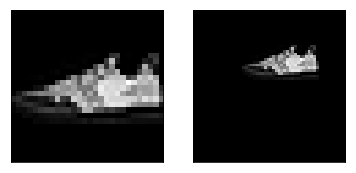

In [6]:
pt,idx = plot_ovt(DL,cmap='gray')

In [7]:
trainer.model

In [8]:
# trainer.build_model()
trainer.compile_model()
# trainer.G.summary()

In [9]:
from keras.layers import Concatenate,Input

In [10]:
G_input = Input(shape=(trainer.config.y_dim+trainer.config.z_dim,))
trainer.Gbuilder(G_input)

<tf.Tensor 'G_image_flat_1/Reshape:0' shape=(?, ?) dtype=float32>

In [11]:
im_input = trainer.input
gen_im = trainer.model.output[0]
latent_vec = Concatenate()([trainer.y_class,trainer.z_lat])

In [12]:
im_stack = Concatenate()([im_input,gen_im])

In [13]:
print(im_input)
print(gen_im)

Tensor("input_image:0", shape=(?, 3136), dtype=float32)
Tensor("G/G_image_flat/Reshape:0", shape=(?, ?), dtype=float32)


In [14]:
trainer.model.output

[<tf.Tensor 'G/G_image_flat/Reshape:0' shape=(?, ?) dtype=float32>,
 <tf.Tensor 'class/Softmax:0' shape=(?, 10) dtype=float32>]

In [15]:
# trainer.G.summary()
G_out = trainer.G.get_layer('G_image_flat')
trainer.E

In [16]:
from keras.utils import to_categorical
RF = to_categorical(np.ones(len(DL.sx_train)),num_classes=2)

In [17]:
trainer.go(x=DL.sx_train,
           y={
               'class':DL.y_train_oh,
#                'D_real':RF,
               'G':DL.sx_train},
           validation_split=0.05,
           verbose=0)

Epoch        G_loss      val_G_loss  val_class_acc
0:           95.7352     59.0819     0.4117      
1:           36.601      40.3672     0.5443      
2:           29.5677     30.1833     0.5813      
3:           26.594      27.942      0.622       
4:           24.7728     24.9893     0.6563      
5:           23.2684     23.2746     0.6803      
6:           22.1228     21.9481     0.6917      
7:           21.151      21.1518     0.7133      
8:           20.4366     20.6948     0.732       
9:           19.6863     19.5575     0.7203      
10:          18.9837     19.1286     0.742       
11:          18.4375     18.9122     0.74        
12:          17.8631     18.216      0.7523      
13:          17.2564     17.565      0.7533      
14:          16.7763     16.932      0.7583      
15:          16.3996     16.5471     0.7543      
16:          16.0774     16.9281     0.7613      
17:          15.7277     16.0604     0.7717      
18:          15.3898     15.8503     0.766       

In [18]:
hist_df = pd.DataFrame.from_records(trainer.model.history.history)
hist_df.head()

,G_loss,G_mse,class_acc,class_loss,loss,val_G_loss,val_G_mse,val_class_acc,val_class_loss,val_loss
0,95.735209,95.735209,0.227842,2.452533,2430.168227,59.081911,59.081911,0.411667,1.565422,1500.529102
1,36.600958,36.600958,0.495895,1.353601,935.327963,40.367159,40.367159,0.544333,1.189284,1027.018240
2,29.567738,29.567738,0.575737,1.123370,756.044014,30.183307,30.183307,0.581333,1.078671,770.762750
3,26.593987,26.593987,0.608649,1.032170,680.332231,27.941953,27.941953,0.622000,0.968224,713.072168
4,24.772798,24.772798,0.642561,0.952344,633.605122,24.989343,24.989343,0.656333,0.932755,638.724911


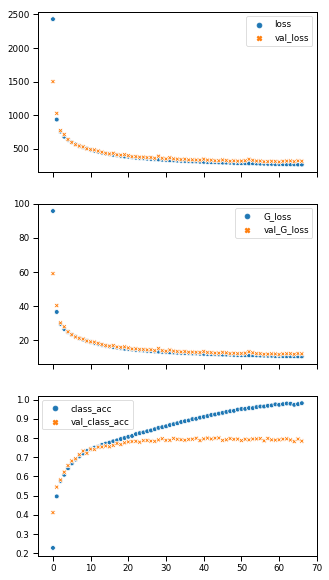

In [19]:
sns.set_context('paper')
metrics = ['loss','G_loss','class_acc']
fig,axs = plt.subplots(nrows=len(metrics),sharex=True,figsize=(5,10))
for metric_name,ax in zip(metrics,axs):
    sns.scatterplot(data=hist_df[[metric_name,'val_'+metric_name]],ax=ax)

In [20]:
# if not config.dev_mode:
# trainer.save_model()

In [21]:
from keras.models import Model
from keras.layers import Input

In [22]:
generator = trainer.G

In [23]:
trainer.E.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, 3136)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 3000)         9411000     input_image[0][0]                
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2000)         6002000     dense_1[0][0]                    
__________________________________________________________________________________________________
enc_merge (Dense)               (None, 36)           72036       dense_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

In [24]:
z_encoder = Model(trainer.input,trainer.z_lat)
classifier = Model(trainer.input,trainer.y_class)
# y_lat_encoder = Model(trainer.E.input,trainer.y_lat)
# decoder_inp = Input(shape=(config.y_dim+config.z_dim,))
# dec_layers = trainer.model.layers[-(1+(5*2)):]
# print(dec_layers)
# _gen_x = dec_layers[0](decoder_inp)
# l = dec_layers[1]
# isinstance(l,keras.layers.core.Reshape)
# F = None
# for l in dec_layers[1:]:
#     print(type(l))
    
#     if isinstance(l,keras.layers.merge.Add):
#         _gen_x = l([F,_gen_x])
#     else:
#         _gen_x = l(_gen_x)
    
#     if isinstance(l,keras.layers.convolutional.Conv2DTranspose):
#         if l.kernel_size==(1,1):
#             F = _gen_x
            
# # generator = Model(decoder_inp,_gen_x)

In [25]:
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3000)              9411000   
_________________________________________________________________
dense_2 (Dense)              (None, 2000)              6002000   
_________________________________________________________________
enc_merge (Dense)            (None, 36)                72036     
_________________________________________________________________
lambda_1 (Lambda)            [(None, 10), (None, 25),  0         
_________________________________________________________________
class (Activation)           (None, 10)                0         
Total params: 15,485,036
Trainable params: 15,485,036
Non-trainable params: 0
________________________________________________________________

In [26]:
DL.y_test_oh.shape

(10000, 10)

In [27]:
classifier.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
classifier.evaluate(DL.sx_test,DL.y_test_oh,batch_size=config.batch_size)

10000/10000 [==============================] - 0s 40us/step


[0.8161487726211548, 0.7844999997138977]

In [28]:
z_enc = z_encoder.predict(DL.sx_test,batch_size=config.batch_size)
# y_lat = y_lat_encoder.predict(DL.sx_test,batch_size=config.batch_size)
y_lat = classifier.predict(DL.sx_test,batch_size=config.batch_size)

In [29]:
_lat_vec = np.concatenate([y_lat,z_enc],axis=1)
_lat_vec.shape

(10000, 35)

In [30]:
z_enc_mu = np.mean(z_enc,axis=0)
z_enc_cov = np.cov(z_enc,rowvar=False)

In [31]:
np.random.multivariate_normal(z_enc_mu,z_enc_cov,size=50).shape

(50, 25)

In [32]:
regen = generator.predict(_lat_vec,batch_size=config.batch_size)

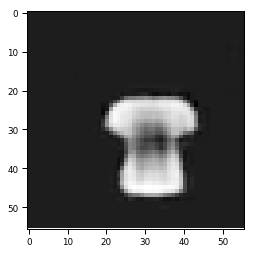

In [33]:
rand_im = np.random.randint(0,10000)
plt.imshow(regen[rand_im].reshape(56,56),cmap='gray')

In [34]:
_lat_vec[rand_im]

array([ 9.9995923e-01,  2.5788392e-11,  5.8200870e-12,  9.9785794e-08,
        2.0776980e-13,  7.1450306e-14,  4.0651517e-05,  5.2772332e-11,
        7.0176309e-09,  1.1213270e-11, -1.8152213e+00,  2.8838745e+01,
       -2.4697449e+00, -1.1066698e+01, -7.6636477e+00, -2.2833841e+00,
        1.5105094e+00,  2.9336615e+00,  6.0484874e-01,  1.4414933e+00,
       -4.2554421e+00,  3.4131846e+00, -5.1291881e+00, -8.0419407e+00,
       -1.7471229e-01, -6.4871287e+00, -4.8231578e+00,  4.6383672e+00,
        4.7979331e+00,  1.0348295e+01, -4.7053523e+00,  1.6166228e+00,
       -5.7169372e-01, -5.1415741e-01, -6.6069758e-01], dtype=float32)

In [35]:
DL2 = Shifted_Data_Loader(dataset=config.dataset,flatten=True,
                         rotation=None,
                         translation=translation_amt,
                        )

input_shape:  (3136,)
dataset:  fashion_mnist
scale:  2
tx_max:  0.8
rot_max:  None
loading fashion_mnist...
sx_train:  (60000, 3136)
making training data...
making testing data...


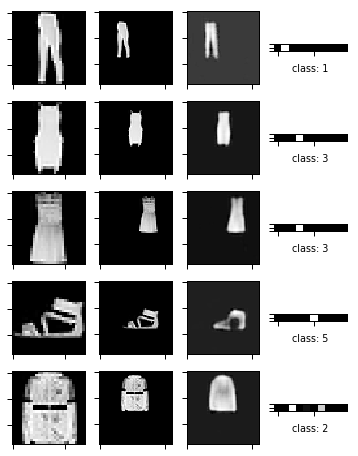

In [36]:
enc_dec_samples(DL.x_test,DL.sx_test,z_enc,y_lat,generator)

In [37]:
z_enc2 = z_encoder.predict(DL2.sx_test,batch_size=config.batch_size)
y_lat2 = classifier.predict(DL2.sx_test,batch_size=config.batch_size)
_lat_vec2 = np.concatenate([y_lat2,z_enc2],axis=1)
regen2 = generator.predict(_lat_vec2,batch_size=config.batch_size)

In [38]:
from src.plot import remove_axes,remove_labels
from src.utils import gen_trajectory

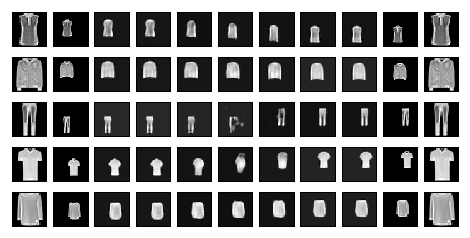

In [39]:
examples = 5
rand_im = np.random.randint(0,10000,size=examples)
fix,axs = plt.subplots(examples,11,figsize=(8,4))
_lat_s = []
regen_s = []
out = gen_trajectory(z_enc[rand_im],z_enc2[rand_im],delta=.25)
out_y = gen_trajectory(y_lat[rand_im],y_lat2[rand_im],delta=.25)

for z,y in zip(out,out_y):
    _lat = np.concatenate([y,z],axis=1)
    _lat_s.append(_lat)
    regen_s.append(generator.predict(_lat,batch_size=config.batch_size))

i=0
for axr,idx in zip(axs,rand_im):
    axr[0].imshow(DL.x_test[idx].reshape(28,28),cmap='gray')
    axr[1].imshow(DL.sx_test[idx].reshape(56,56),cmap='gray')
    axr[2].imshow(regen[idx].reshape(56,56),cmap='gray')
    for j,a in enumerate(axr[3:-3]):
        a.imshow(regen_s[j][i,:].reshape(56,56),cmap='gray')
#         a.imshow(s.reshape(56,56),cmap='gray')
    axr[-3].imshow(regen2[idx].reshape(56,56),cmap='gray')
    axr[-2].imshow(DL2.sx_test[idx].reshape(56,56),cmap='gray')
    axr[-1].imshow(DL2.x_test[idx].reshape(28,28),cmap='gray')
    for a in axr:
        remove_axes(a)
        remove_labels(a)
    i+=1
# plt.imshow(regen[rand_im].reshape(56,56),cmap='gray')

In [40]:
fix.savefig('../../updates/2019-02-05/assets/img/translocate_{}.png'.format(translation_amt))

In [41]:
dxs = DL.dx[1]-14
dys = DL.dy[1]-14

In [42]:
from sklearn.preprocessing import MinMaxScaler

feat_range = (0,50)
z_enc_scaled = [MinMaxScaler(feat_range).fit_transform(z_enc[:,i].reshape(-1,1)).tolist() for i in np.arange(25)]
z_enc_scaled = np.squeeze(np.array(z_enc_scaled,dtype=int))

In [43]:
from collections import Counter
import dit
from dit import Distribution

def mutual_information(X,Y):
    XY_c = Counter(zip(X,Y))
    XY_pmf = {k:v/float(sum(XY_c.values())) for k,v in XY_c.items()}
    XY_jdist = Distribution(XY_pmf)
        
    return dit.shannon.mutual_information(XY_jdist,[0],[1])

In [44]:
z_dx_I = [mutual_information(z_enc_scaled[i],dxs.astype(int)+14) for i in np.arange(25)]

In [45]:
z_dy_I = [mutual_information(z_enc_scaled[i],dys.astype(int)+14) for i in np.arange(25)]

In [46]:
z_class_I = [mutual_information(z_enc_scaled[i],DL.y_test) for i in np.arange(25)]

In [47]:
z_I_df = pd.DataFrame.from_records({'class':z_class_I,'dy':z_dy_I,'dx':z_dx_I})
z_I_df['class'] = z_I_df['class'].values.round(decimals=1)

In [48]:
config.translation_amt = translation_amt
config.translation_amt

0.8

In [49]:
dir_path = '../data/xcov_importance/dist_{}/'.format(translation_amt)

z_I_df.to_pickle('../data/xcov_importance/dist_{}/z_mutual_info.pk'.format(translation_amt))
np.save('../data/xcov_importance/dist_{}/dxs'.format(translation_amt), DL.dx[1]-14)
np.save('../data/xcov_importance/dist_{}/dys'.format(translation_amt), DL.dy[1]-14)
np.save('../data/xcov_importance/dist_{}/z_enc'.format(translation_amt), z_enc)

hist_df.to_pickle(os.path.join(dir_path,'training_hist.df'))

with open(os.path.join(dir_path,'config.json'), 'w') as fp:
        json.dump(vars(config), fp)

FileNotFoundError: [Errno 2] No such file or directory: '../data/xcov_importance/dist_0.8/z_mutual_info.pk'

In [ ]:
sns.set_context('talk')
fig,ax = plt.subplots(1,1,figsize=(6,5))
ax.set_ylim(0,0.9)
ax.set_xlim(0,0.9)
points = plt.scatter(x=z_I_df['dx'],y=z_I_df['dy'],c=z_I_df['class'],cmap='plasma')
plt.colorbar(points)

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter(z_dx_I,z_dy_I)
# ax.set_ylim(0,0.8)
# ax.set_xlim(0,0.8)

In [ ]:
plt.scatter(np.arange(25),sorted(z_class_I,reverse=True))
# plt.scatter(np.arange(25),z_dx_I)
# plt.scatter(np.arange(25),z_dy_I)

In [ ]:
from src.metrics import var_expl,norm_var_expl
from collections import Counter

dtheta = DL.dtheta[1]
fve_dx = norm_var_expl(features=z_enc,cond=dxs,bins=21)
fve_dy = norm_var_expl(features=z_enc,cond=dys,bins=21)
fve_class = norm_var_expl(features=z_enc, cond=DL.y_test, bins=21)
# fve_dt = norm_var_expl(features=z_enc,cond=dtheta,bins=21)

In [ ]:
# fve_dx_norm = (dxs.var()-fve_dx)/dxs.var()
# fve_dy_norm = (dys.var()-fve_dy)/dys.var()
# fve_dth_norm = (dtheta.var()-fve_dt)/dtheta.var()
fve_dx_norm = fve_dx
fve_dy_norm = fve_dy

In [ ]:
import seaborn as sns
sns.set_context('talk')

In [ ]:
fve_dx_norm.shape
# np.save(os.path.join(config.model_dir,'fve_dx_norm'),fve_dx_norm)

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
plt.scatter(fve_dx_norm.mean(axis=0),fve_dy_norm.mean(axis=0))
plt.xlabel('fve_dx')
plt.ylabel('fve_dy')
plt.tight_layout()
# plt.savefig(os.path.join(config.model_dir,'fve_dx.png'))
# plt.ylim(-0.125,0.25)
xdim = np.argmax(fve_dx_norm.mean(axis=0))

In [ ]:
fve_dy_norm.mean(axis=0)
# np.save(os.path.join(config.model_dir,'fve_dy_norm'),fve_dy_norm)

In [ ]:
plt.scatter(np.arange(config.z_dim),fve_dy_norm.mean(axis=0))
plt.xlabel('Z_n')
plt.ylabel('fve_dy')
plt.tight_layout()
# plt.savefig(os.path.join(config.model_dir,'fve_dy.png'))
# plt.ylim(-0.125,0.25)
ydim = np.argmax(fve_dy_norm.mean(axis=0))

In [ ]:
plt.scatter(np.arange(config.z_dim),fve_class.mean(axis=0))
plt.xlabel('Z_n')
plt.ylabel('fve_class')
# plt.ylim(0.0,0.5)
np.argmax(fve_class.mean(axis=0))

In [ ]:
from src.plot import Z_color_scatter
Z_color_scatter(z_enc,[xdim,ydim],dxs)

In [ ]:
Z_color_scatter(z_enc,[xdim,ydim],dys)

In [ ]:
Z_color_scatter(z_enc,[7,18],dtheta)

In [ ]:
from plt.